# Homework (15 pts) - Regularization

In [8]:
import numpy as np
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'
plt.style.use('bmh')
plt.rcParams['lines.markeredgecolor'] = 'w'
plt.rcParams['lines.markeredgewidth'] = 0.5
plt.rcParams['figure.figsize'] = [8, 6]

In [9]:
# data from Jonathan Pillow's lab: https://github.com/pillowlab/GLMspiketraintutorial
stimulus = np.load('retinal_ganglion_stimulus.npy')
spikes = np.load('retinal_ganglion_spikes.npy')

stimulus.shape, spikes.shape

((20000,), (20000,))

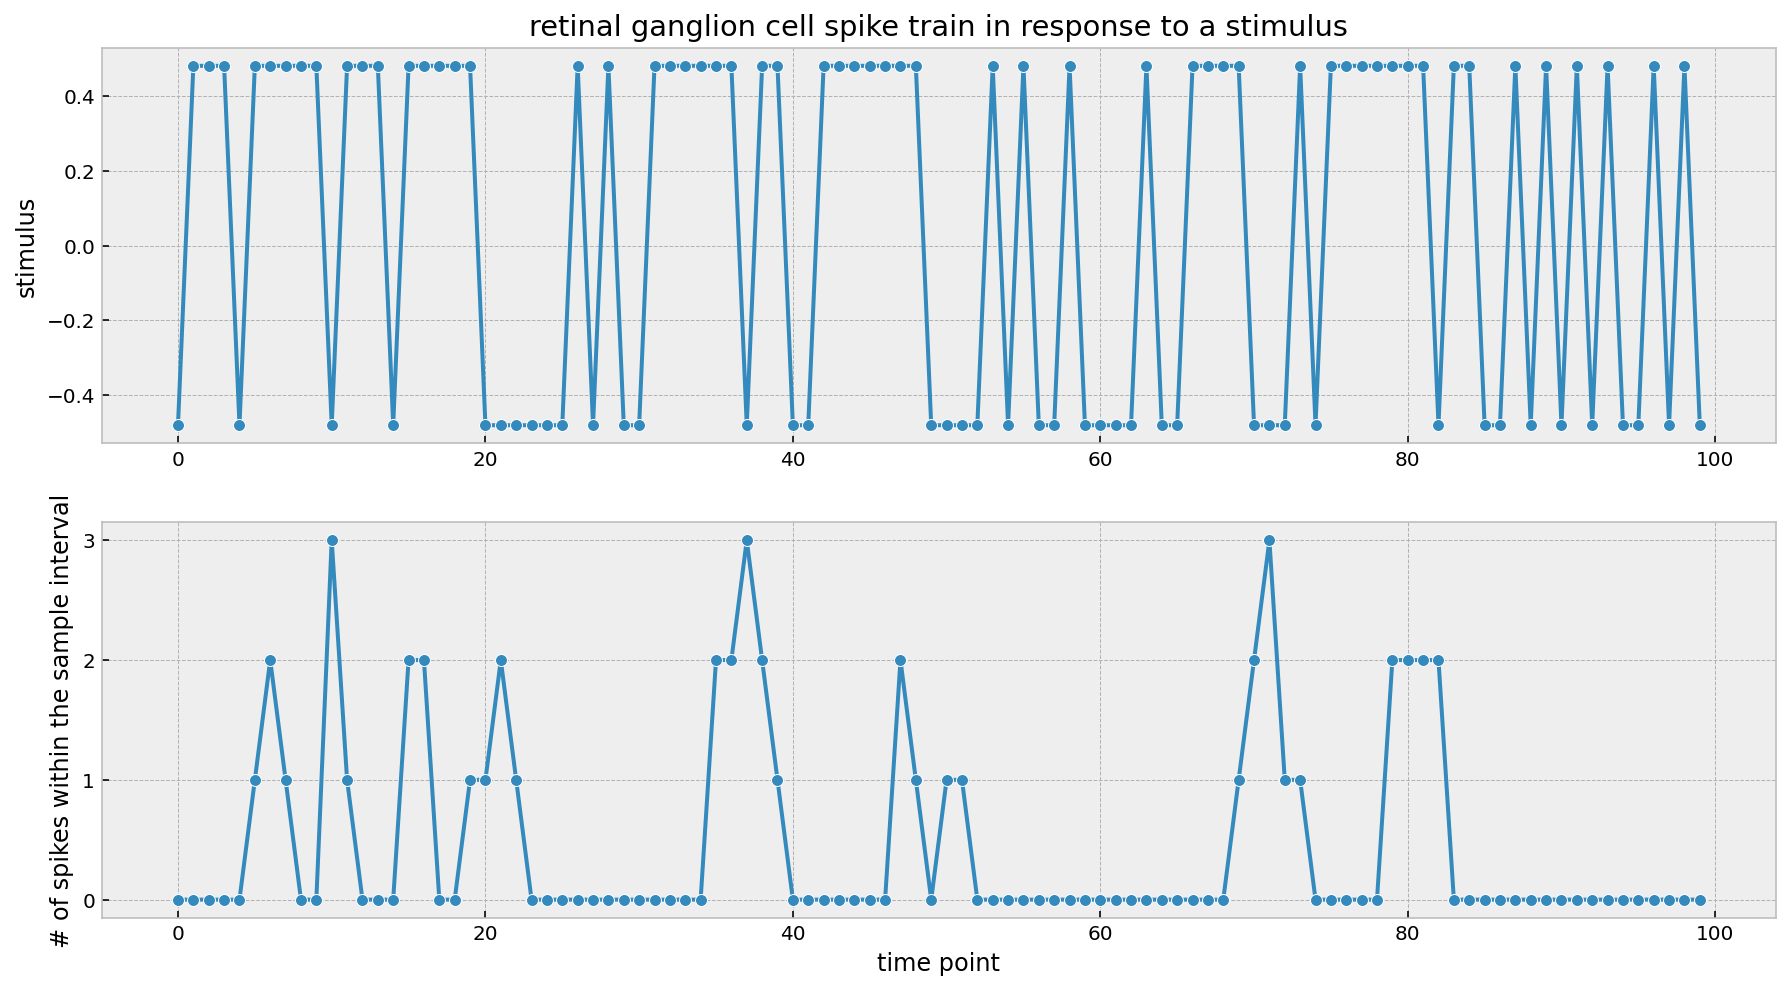

In [10]:
# retinal ganglion stimulus and spike data
plt.figure(figsize=[15,8])
plt.subplot(211)
plt.plot(stimulus[:100], 'o-')
plt.ylabel('stimulus')
plt.title('retinal ganglion cell spike train in response to a stimulus')
plt.subplot(212)
plt.plot(spikes[:100], 'o-')
plt.yticks(range(4))
plt.ylabel('# of spikes within the sample interval')
plt.xlabel('time point');

---
1. (6 pts) Consider a Poisson GLM model that predicts the number of spikes within each time interval based on the stimulus during a window period preceding and inluding the current time point (just as we did in class). See the function `stimulus_to_X` below for generating the matrix of prediction windows for each time point (each row of X) where the columns of X correspond to the window size used for prediction (i.e., the number of predictors). Try a bunch of different window lengths to see which is best (see `window_lengths` below). For each window length, use 10-fold cross validation to determine the optimal regularization strengths $\alpha$ (try values of $\alpha$ in `alphas` below). For each value of window length and alpha, store the mean and standard deviation for the mean squared error across validation folds in the variables `cv_mse_mean` and `cv_mse_std`.

In [84]:
def stimulus_to_X(stimulus, window_length):
    T = len(stimulus)
    X = np.zeros((T, window_length))
    for t in range(T):
        if t < window_length-1:
            X[t,-t-1:] = stimulus[:t+1]  # last t columns of row t
        else:
            X[t,:] = stimulus[t-window_length+1:t+1]  # full row t
    return X

In [85]:
window_lengths = np.arange(10, 31, 5)
alphas = np.logspace(-4, 1, 25)

In [86]:
# allocate memory for storing cross validated mean squared errors
cv_mse_mean = np.zeros([len(window_lengths), len(alphas)])
cv_mse_std = np.zeros([len(window_lengths), len(alphas)])

In [88]:
from sklearn.linear_model import PoissonRegressor
from sklearn.model_selection import GridSearchCV

# Predictors and response data.
# X will be different for each window length.
y = spikes

# randomly shuffled indices for each response
ind = np.arange(len(y))
np.random.shuffle(ind)

# for each window length...
for i, w in enumerate(window_lengths):
    print(f'Window length = {w}...')
    
    # get predictors matrix X based on window length
    X = stimulus_to_X(stimulus, w)
    
    # Perform 10-fold cross validation on a Poisson GLM model
    # for each regularization strength alpha.
    # Use mean squared error to score.
    model = PoissonRegressor()
    param_grid = {'alpha': alphas}
    cv = GridSearchCV(model, param_grid, cv=10, scoring='neg_mean_squared_error')
    cv.fit(X[ind], y[ind])
    
    # Store the mean and standard deviation of the mean squared error
    # across the 10 validation folds.
    cv_mse_mean[i,:] = -cv.cv_results_['mean_test_score']
    cv_mse_std[i,:] = cv.cv_results_['std_test_score']
    
print('Done')

Window length = 10...
Window length = 15...
Window length = 20...
Window length = 25...
Window length = 30...
Done


---
2. (3 pts) Based on the cross-validated mean squared errors (MSEs) you computed above, find the window length and regularization strength $\alpha$ with the lowest MSE.

In [95]:
row = np.argmin(cv_mse_mean.max(axis=1))
col = np.argmin(cv_mse_mean.max(axis=0))

best_window_length = window_lengths[row]
best_alpha = alphas[col]

best_window_length, best_alpha

(20, 0.007498942093324558)

---
3. (3 pts) For the best window length, plot the MSE vs. $\alpha$. Similarly, for the best $\alpha$, plot the MSE vs. window length. In both cases, plot the mean cross-validated MSE and indicate the envelope within a standard deviation with a shaded region.

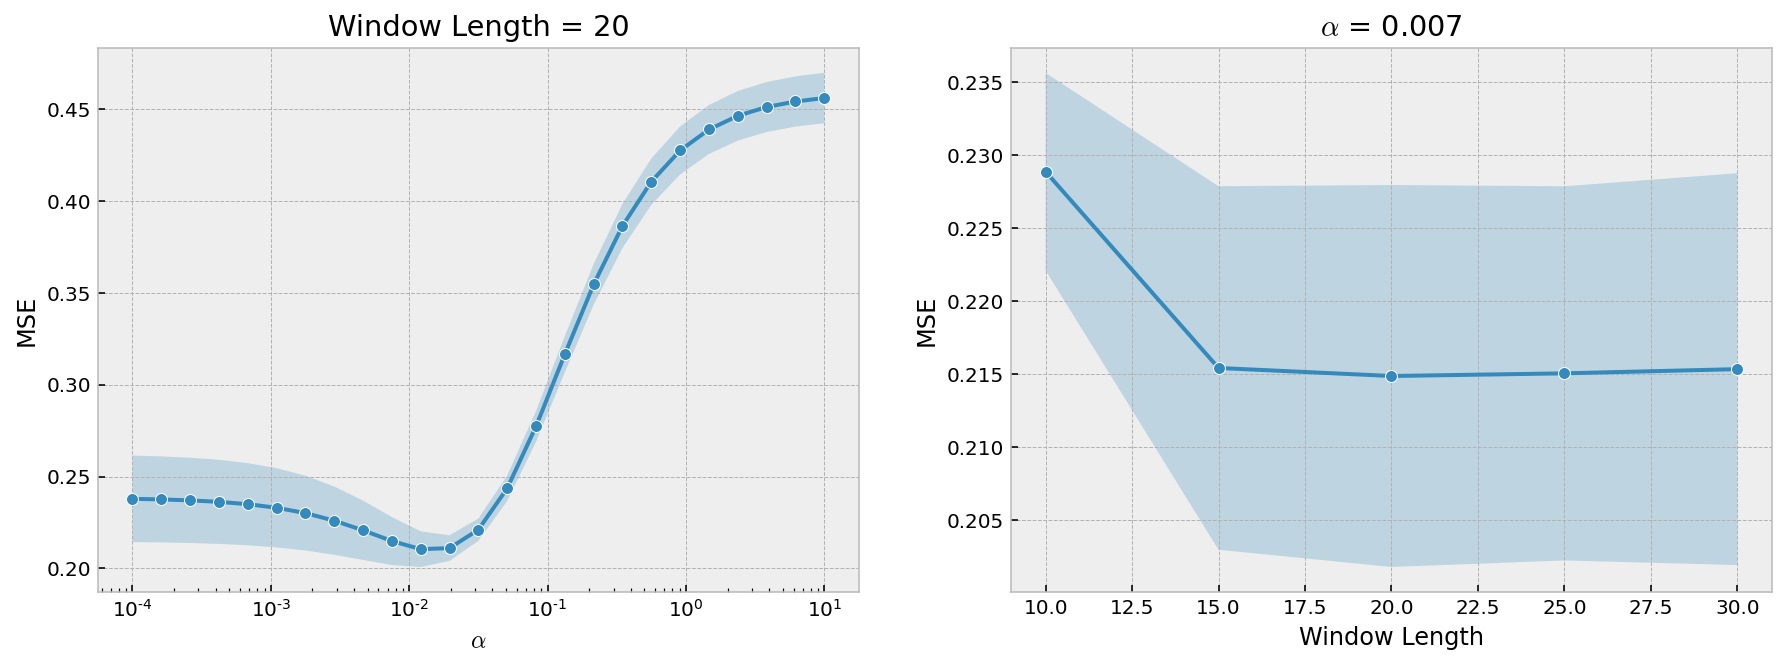

In [97]:
plt.figure(figsize=[15,5])
plt.subplot(121)
mse_mean = cv_mse_mean[row]
mse_std = cv_mse_std[row]
plt.plot(alphas, mse_mean, 'o-')
plt.fill_between(alphas, mse_mean - mse_std, mse_mean + mse_std, alpha=0.25)
plt.xscale('log')
plt.xlabel(r'$\alpha$')
plt.ylabel('MSE')
plt.title(f'Window Length = {best_window_length}')

plt.subplot(122)
mse_mean = cv_mse_mean[:,col]
mse_std = cv_mse_std[:,col]
plt.plot(window_lengths, mse_mean, 'o-')
plt.fill_between(window_lengths, mse_mean - mse_std, mse_mean + mse_std, alpha=0.25)
plt.xlabel('Window Length')
plt.ylabel('MSE')
plt.title(fr'$\alpha$ = {best_alpha:.3f}');

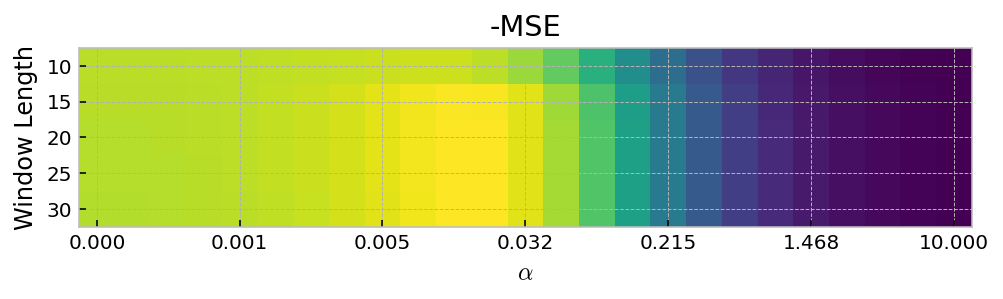

In [100]:
# this is extra just for fun
plt.imshow(-cv_mse_mean)
plt.xticks(range(0, len(alphas), 4), [f'{alpha:0.3f}' for alpha in alphas[::4]])
plt.yticks(range(len(window_lengths)), window_lengths)
plt.xlabel(r'$\alpha$')
plt.ylabel('Window Length')
plt.title('-MSE');

---
4. (3 pts) What does the above plot tell you about the dependence of your model on the window length?

A window length of 10 is too short to accurately predict the spike count, whereas a window length of more than 15 does not provide any real added benefit to the prediction. Thus, this model suggests that the spike count is primarily dependent on the stimulus during the preceding 15 time points.